<a href="https://colab.research.google.com/github/YazCodes/heartRatePrediction/blob/main/PredictHeartRate_TimeSeries_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from scipy import linalg
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline
#from quantecon import Kalman, LinearStateSpace
from scipy.stats import norm
from scipy.integrate import quad
from numpy.random import multivariate_normal
from scipy.linalg import eigvals
from scipy import signal
from sklearn.decomposition import FastICA, PCA
from numpy import dot
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import matplotlib

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#Load the data 
df = pd.read_csv("PT_Train.csv")
df.head(20) #first 20 data points
df.tail() #looking at the last minutes of heartrate and where to start the prediction  

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
221,17/08/2015 18:50,159,51,NaN,NaN
222,17/08/2015 18:51,151,64,NaN,NaN
223,17/08/2015 18:52,140,64,NaN,NaN
224,17/08/2015 18:53,140,55,NaN,NaN
225,17/08/2015 18:54,138,54,NaN,NaN


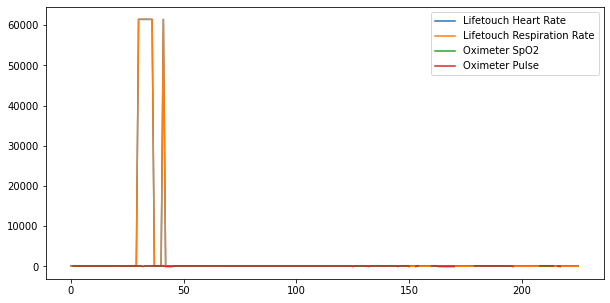

In [4]:
#Plot our data
df = pd.read_csv("PT_Train.csv")


matplotlib.rc('figure', figsize=(10, 5))
df.plot()
#This is what my date time series looks like - messy and not useful 
#Error on the Y axis range, due to the code given to the mesurements when there is bad data. values above 1000 need to be cut off 

In [ ]:
#Data cleaning 


In [5]:
#Data cleaning  - Important step as the ML model and data processing cannot start if the dataset contains missing values

df.isnull().values.any() #This shows if there are any missing values in the dataset. True = yes false = No

df = df.dropna() #drop any rows with missing values 

print(f'Number of entries: {len(df)}') #check if the number of entries have changed

Number of entries: 191


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

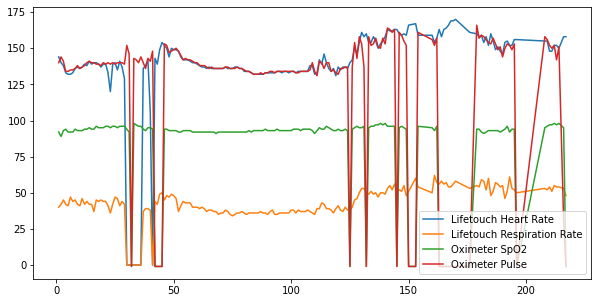

In [6]:

#Cut off function
def cutoff(row):
    vals = row
    if vals>1000:
        vals = 0  #Any value > 1000 will be set to 0 
    return vals

matplotlib.rc('figure', figsize=(10, 5))
df['Lifetouch Heart Rate'] = df['Lifetouch Heart Rate'].apply(cutoff)
df['Lifetouch Respiration Rate'] = df['Lifetouch Respiration Rate'].apply(cutoff)
df['Oximeter SpO2'] = df['Oximeter SpO2'].apply(cutoff)
df['Oximeter Pulse'] = df['Oximeter Pulse'].apply(cutoff)
df.plot()

#blue = heart rate 
#red = pulse rate 

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1671: RuntimeWarning: invalid value encountered in subtract
  resids = x - x.mean()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. 


Result: The series is stationary



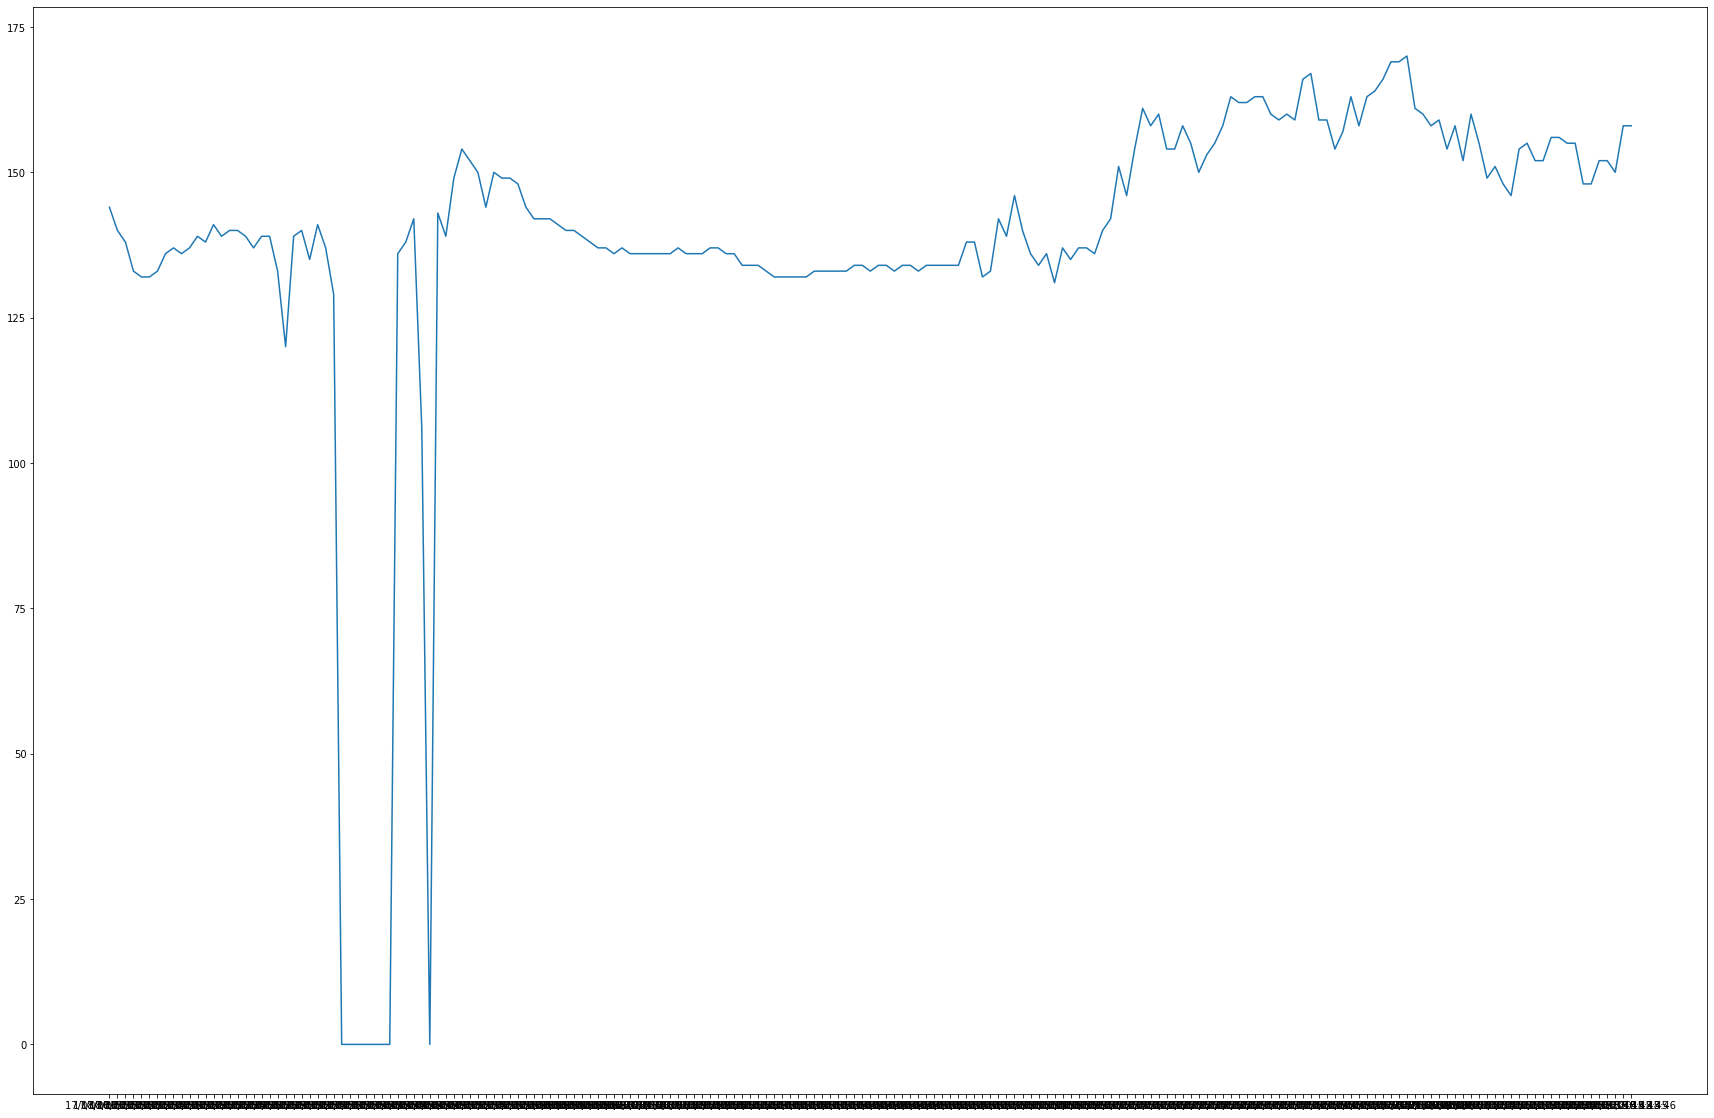

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse,stationary
1,17/08/2015 15:10,144,40,92.0,140.0,4.969813
2,17/08/2015 15:11,140,42,89.0,144.0,4.941642
3,17/08/2015 15:12,138,45,93.0,141.0,4.927254
4,17/08/2015 15:13,133,42,94.0,134.0,4.890349
5,17/08/2015 15:14,132,41,92.0,134.0,4.882802


In [ ]:
#Step one - check if data is stationary using the KPSS test 

df['stationary'] = np.log(df['Lifetouch Heart Rate']) # get rid of peaks and troffs using the log function, create a new column called stationary


statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(df['stationary']) 
print(f'\nResult: The series is {"not " if p_value < 0.05 else ""}stationary\n')

plt.plot(df['Timestamp (GMT)'],df['Lifetouch Heart Rate'])
plt.show()
df.head()


#results show data is stationary - meaning the mean, variance and covariance do not vary with time. - 

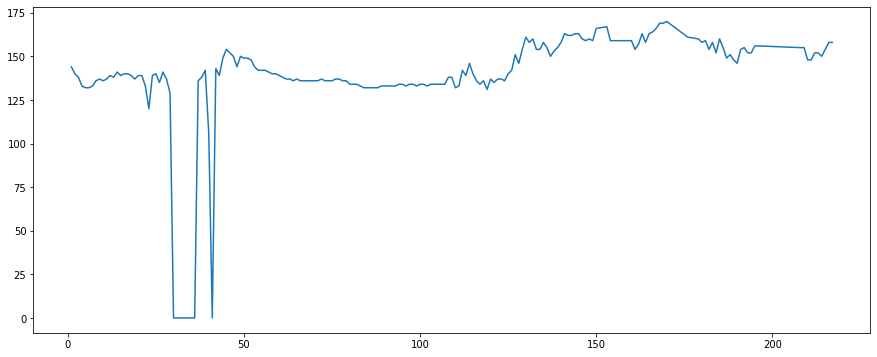

In [8]:
#ARIMA model 
#ploting only the heartrate data 
y = df['Lifetouch Heart Rate'] 


y = y.fillna(y.bfill())
y.plot(figsize=(15, 6))




In [ ]:
import itertools
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq = [(0, 0, 0, 0)]  # change to 0000 - As the data is not affected by seasonality 
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

#Selecting an ARIMA model order 
#Results show that this is the best result - ARIMA(2, 1, 2)x(0, 0, 0, 0)12 - AIC:1890.9735397323443 -This ARIMIA model has the lowest error rate.
#The Akaike Information Critera (AIC) is a widely used measure of a statistical model. It basically quantifies 1) the goodness of fit, and 2) the simplicity/parsimony, of the model

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was pro

ARIMA(0, 0, 0)x(0, 0, 0, 0)12 - AIC:2423.243891195396
ARIMA(0, 0, 1)x(0, 0, 0, 0)12 - AIC:2172.175128186237
ARIMA(0, 0, 2)x(0, 0, 0, 0)12 - AIC:2045.2617605689413
ARIMA(0, 1, 0)x(0, 0, 0, 0)12 - AIC:1658.0431114142493
ARIMA(0, 1, 1)x(0, 0, 0, 0)12 - AIC:1646.51107385546
ARIMA(0, 1, 2)x(0, 0, 0, 0)12 - AIC:1638.622821088628
ARIMA(0, 2, 0)x(0, 0, 0, 0)12 - AIC:1808.4109506841746
ARIMA(0, 2, 1)x(0, 0, 0, 0)12 - AIC:1648.6833763035538
ARIMA(0, 2, 2)x(0, 0, 0, 0)12 - AIC:1637.3228664013236
ARIMA(1, 0, 0)x(0, 0, 0, 0)12 - AIC:1667.063475616478
ARIMA(1, 0, 1)x(0, 0, 0, 0)12 - AIC:1655.8574786502281


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 2)x(0, 0, 0, 0)12 - AIC:1648.2122605267366
ARIMA(1, 1, 0)x(0, 0, 0, 0)12 - AIC:1655.1794152347002
ARIMA(1, 1, 1)x(0, 0, 0, 0)12 - AIC:1637.5787229006833


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 2)x(0, 0, 0, 0)12 - AIC:1631.5575722994809
ARIMA(1, 2, 0)x(0, 0, 0, 0)12 - AIC:1742.514116643354
ARIMA(1, 2, 1)x(0, 0, 0, 0)12 - AIC:1646.2075593234904


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 2, 2)x(0, 0, 0, 0)12 - AIC:1631.133688921946
ARIMA(2, 0, 0)x(0, 0, 0, 0)12 - AIC:1656.6593221898179
ARIMA(2, 0, 1)x(0, 0, 0, 0)12 - AIC:1645.606438250845


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(2, 0, 2)x(0, 0, 0, 0)12 - AIC:1638.8229715368384
ARIMA(2, 1, 0)x(0, 0, 0, 0)12 - AIC:1648.5078246942976
ARIMA(2, 1, 1)x(0, 0, 0, 0)12 - AIC:1639.4643148584737


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(2, 1, 2)x(0, 0, 0, 0)12 - AIC:1625.3788026255834
ARIMA(2, 2, 0)x(0, 0, 0, 0)12 - AIC:1712.9216478727194
ARIMA(2, 2, 1)x(0, 0, 0, 0)12 - AIC:1647.6698417961074


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(2, 2, 2)x(0, 0, 0, 0)12 - AIC:1630.354851036508


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1287      0.068     -1.897      0.058      -0.262       0.004
ar.L2          0.6479      0.048     13.568      0.000       0.554       0.742
ma.L1          0.0300    556.883   5.39e-05      1.000   -1091.440    1091.500
ma.L2         -0.9700    540.201     -0.002      0.999   -1059.744    1057.804
sigma2       319.9280   1.78e+05      0.002      0.999   -3.49e+05     3.5e+05


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


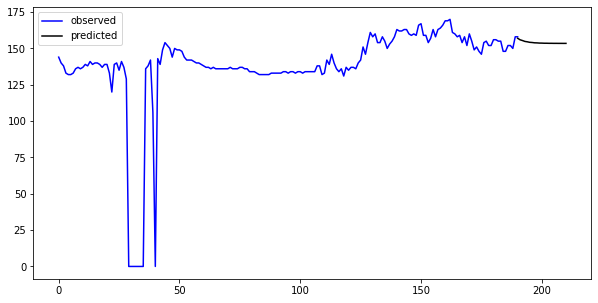

191    156.981247
192    155.946852
193    155.419916
194    154.817529
195    154.553647
196    154.197310
197    154.072200
198    153.857423
199    153.804005
200    153.671722
201    153.654137
202    153.570691
203    153.570038
204    153.516055
205    153.522580
206    153.486764
207    153.495601
208    153.471258
209    153.480117
210    153.463204
211    153.471121
dtype: float64


In [9]:

# specify model - using above results 
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(2, 1, 2), #got from previous code results 
                                seasonal_order=(0, 0, 0, 0),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
# fit model
results = mod.fit()
print(results.summary().tables[1])
# make predictions
pred = results.get_prediction(start=len(y),end=len(y)+20, dynamic=False) #The start is set to the end of y and the end is set 20 minutes after y 
pred_ci = pred.conf_int()


plt.plot(range(0,len(y)),y,color='b',label='observed')
y_forecasted = pred.predicted_mean
plt.plot(range(len(y)-1,len(y)+20),y_forecasted,color='k',label='predicted')

#plt.set_xlabel('Timestamp (GMT)')
#plt.set_ylabel('Lifetouch Heart Rate')
plt.legend()

plt.show()

print(y_forecasted) #printing the predicted next 20 miniutes of heart rate


#y_truth = y['17/08/2015 18:54:00':]  

# Compute the mean square error
#mse = ((y_forecasted - y_truth) ** 2).mean()
#print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))